# Probability Estimation and Calibration

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from venn_abers import VennAbersCalibrator, VennAbers

from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import brier_score_loss, mean_squared_error, log_loss, accuracy_score
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn.utils import check_random_state
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA


<div align="justify">

The predictions delivered by corresponding methods are at best "pseudo-probabilities" that are often not very accurate. 
Besides, there are many methods that deliver natural scores, 
intuitively expressing a degree of confidence 
(like the distance from the [separating hyperplane in support vector machines](svm)), 
but which do not immediately qualify as probabilities either. 
The idea of *scaling* or *calibration methods* is to turn such scores into proper, 
well-calibrated probabilities, that is, 
to learn a mapping from scores to the unit interval that can be applied to the output of a predictor as a kind of post-processing step ({cite:t}`flac_cc17`). 
Examples of such methods include [binning](binning) ({cite:t}`zadr_oc01`), 
[isotonic regression](ir) ({cite:t}`zadr_tc02`), 
[logistic scaling](ls) ({cite:t}`Pla00`) 
and improvements thereof ({cite:t}`kull_bc17`), 
as well as the use of [Venn predictors](vp) ({cite:t}`joha_vp18`). 
Calibration is still a topic of ongoing research. 

</div>

<div align="justify">

Calibration is generally associated with classification tasks where we aim to adjust the predicted probabilities to better reflect the true likelihood of outcomes. 
The aim of calibration in binary classification is to take an uncalibrated scoring classifier $s=f(x)$ and apply a calibration map $\mu$ on top of it to produce calibrated probabilities $\mu(f(x))$. 
Formally, a scoring classifier is perfectly calibrated on a dataset if for each of its output scores $s$ the proportion of positives within instances with model output score $s$ is equal to $s$. 
Denoting the instances in the dataset by $\vec{x}_1, \cdots, \vec{x}_n$ and their binary labels by $y_1, \cdots, y_n$, 
a model $f$ is calibrated on this dataset if for each of its possible outputs $s_i = f(x_i)$ the following holds:

$$
s_i = \mathbb{E}[Y\vert f(X)=s_i],
$$

where the random variables $X$, $Y$ denote respectively the features and label of a uniformly randomly drawn instance from the dataset, 
the labels $Y = 1$ and $Y = 0$ stand for a positive and negative, respectively. 
This expectation can be rewritten as follows: 

$$
\mathbb{E}[Y\vert f(X)=s_i] = \frac{\sum_{j=1}^n y_j \cdot I[f(x_j)=s_i]}{\sum_{j=1}^n I[f(x_j)=s_i]},
$$

where $I[\cdot]$ is the indicator function. 
For any fixed model $f$ there exists a uniquely determined calibration map which produces perfectly calibrated probabilities on the given dataset. 
That calibration map can be defined as $\mu(s_i) = \mathbb{E}[Y\vert f(X)=s_i]$. 
However, usually we do not want to learn perfect calibration maps on the training data, 
because these would overfit and would be far from being calibrated on the test data ({cite:t}`kull_bc17`). 

</div>

(svm)=
## Separating Hyperplane in Support Vector Machines

<div align="justify">

For having a better understanding, 
let us first generate a synthetic binary classification dataset, 
then we create a support vector machine (SVM) with a `linear` kernel and separate the hyperplane in this SVM. 

</div>

In [42]:
X, y = make_blobs(n_samples=200, centers=2, random_state=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel="linear", C=1000, probability=True, random_state=42)
svm.fit(X_train, y_train)

SVC(C=1000, kernel='linear', probability=True, random_state=42)

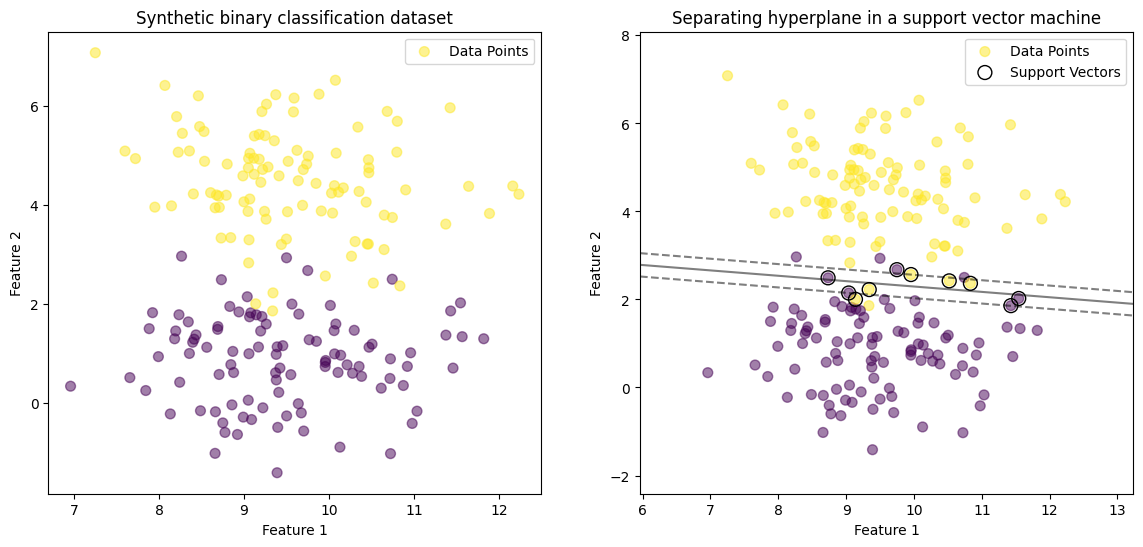

In [43]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', alpha=0.5)
ax0.set_title('Synthetic binary classification dataset')
ax0.legend(['Data Points'])
ax0.set_xlabel('Feature 1')
ax0.set_ylabel('Feature 2')

ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', alpha=0.5)
ax1.set_title('Separating hyperplane in a support vector machine')
DecisionBoundaryDisplay.from_estimator(svm, X, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax1)
ax1.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100, linewidth=1, facecolors="none", edgecolors="k")
ax1.legend(('Data Points', 'Support Vectors')) # , loc="lower right"
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

plt.show()

<div align="justify">

The solid line denotes the optimal hyperplane (best decision boundary), 
while the space between dashed lines is the margin. 
The data points with black circles are support vectors. 

</div>

(binning)=
### Binning

<div align="justify">

Binning assigns the same probability estimate to all examples in each bin, 
the ranking of examples inside bins is lost. 
The number of different probability estimates that binning can yield is limited by the number of alternative bins.
Binning reduces the resolution, i.e., the degree of detail, 
of conditional probability estimates, 
while improving the accuracy of these estimates by reducing both variance and bias compared to uncalibrated estimates. 

If the shape of the mapping function is unknown, 
we can resort to a non-parametric method such as binning. 
In binning, the training examples are sorted according to their scores and the sorted set is divided into different subsets of equal size, 
called bins ({cite:t}`zadrozny_learning_2001,zadr_oc01`). 

</div>

<div align="justify">

*Expected Calibration Error* (ECE) and *Maximum Calibration Error* (MCE) are two common measures for the calibration. 
Specifically, 
ECE calculates the weighted average of the absolute differences between the predicted probabilities and the actual outcomes for each bin, 
while MCE identifies the maximum absolute difference between the predicted probabilities and the actual outcomes across all bins. 

The Expected Calibration Error is defined as follows: 

$$
    \text{ECE} = \sum_{k=1}^{K} \frac{|B_k|}{N} \left| \text{acc}(B_k) - \text{conf}(B_k) \right|,
$$

where $\text{acc}(B_k)$ and $\text{conf}(B_k)$ are the average accuracy and confidence of the $k$-th bin respectively.
A lower ECE indicates better uncertainty calibration.

In high-risk applications where reliable confidence measures are absolutely necessary, 
we may wish to minimize the worst-case deviation between confidence and accuracy. 
The Maximum Calibration Error can be represented: 

$$
    \text{MCE} = \max_{k \in \{ 1, \dots, K \}} \left| \text{acc}(B_k) - \text{conf}(B_k) \right|.
$$

</div>

In [44]:
def calculate_ece(prob_true, prob_pred, n_bins):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_mask = (prob_pred >= bin_edges[i]) & (prob_pred < bin_edges[i+1])
        if np.sum(bin_mask) > 0:
            bin_confidence = np.mean(prob_pred[bin_mask])
            bin_accuracy = np.mean(prob_true[bin_mask])
            bin_size = np.mean(bin_mask)
            ece += bin_size * np.abs(bin_accuracy - bin_confidence)
    return ece

def calculate_mce(prob_true, prob_pred, n_bins):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    mce = 0.0
    for i in range(n_bins):
        bin_mask = (prob_pred >= bin_edges[i]) & (prob_pred < bin_edges[i+1])
        if np.sum(bin_mask) > 0:
            bin_confidence = np.mean(prob_pred[bin_mask])
            bin_accuracy = np.mean(prob_true[bin_mask])
            mce = max(mce, np.abs(bin_accuracy - bin_confidence))
    return mce

<div align="justify">

Let us see the influence of different bins for the calibration. 
We plot below three calibration curves for different numbers of bins (5, 10, and 20). 
We can visualize MCE and ECE on reliability diagrams. 
For perfectly (ideally) calibrated classifiers, 
MCE and ECE both equal 0 ({cite:t}`guo_calibration_2017`). 

</div>

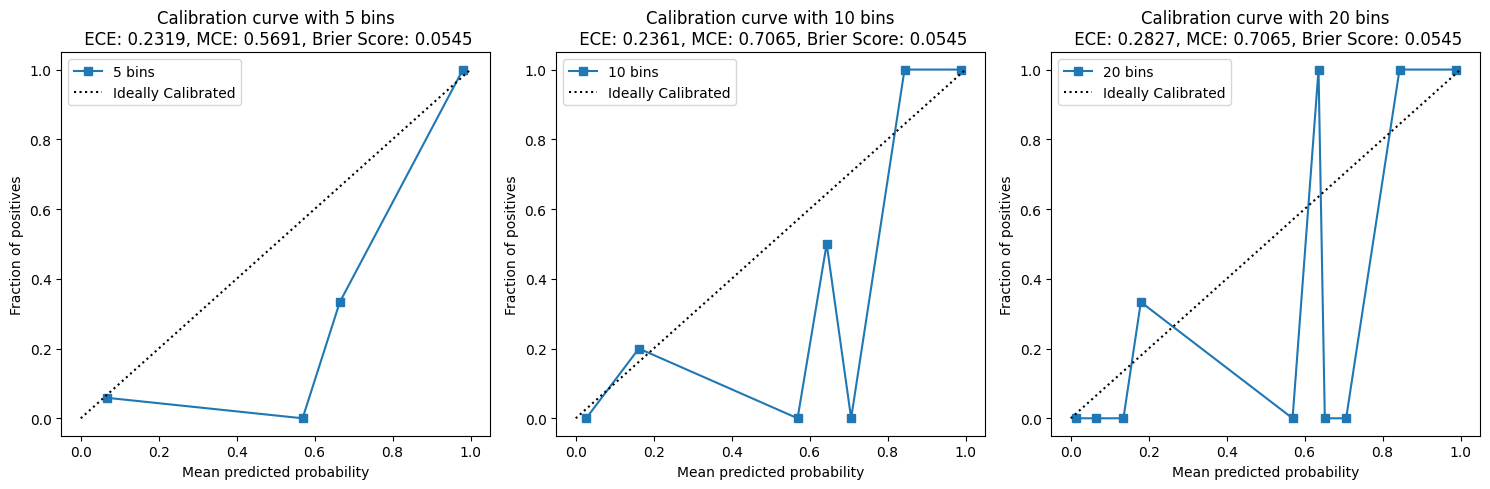

In [46]:
y_prob = svm.predict_proba(X_test)[:, 1]

bins_list = [5, 10, 20]
results = []

plt.figure(figsize=(15, 5))
for i, bins in enumerate(bins_list):
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=bins, strategy='uniform')
    
    brier_score = brier_score_loss(y_test, y_prob)
    ece = calculate_ece(prob_true, prob_pred, bins)
    mce = calculate_mce(prob_true, prob_pred, bins)
    
    results.append((bins, ece, mce, brier_score)) 
    
    plt.subplot(1, len(bins_list), i+1)
    plt.plot(prob_pred, prob_true, "s-", label=f'{bins} bins')
    plt.plot([0, 1], [0, 1], linestyle='dotted', color='black', label='Ideally Calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration curve with {bins} bins\n ECE: {ece:.4f}, MCE: {mce:.4f}, Brier Score: {brier_score:.4f}') 
    plt.legend()

plt.tight_layout()
plt.show()


<div align="justify">

Obviously we can see, with fewer bins (e.g., 5 bins), each bin contains more samples, 
leading to a smoother but less detailed calibration curve. 
This can sometimes obscure finer details of the calibration performance of the model. 
With more bins (e.g., 20 bins), each bin contains fewer samples, 
providing a more detailed view of the calibration. 
However, this can introduce more noise, 
especially when some bins have very few samples.

</div>

(ls)=
### Logistic Scaling 

<div align="justify">

 Introduced by {cite:t}`Pla00`, logistic (Platt) scaling was originally a method for calibrating support vector machines. 
 It works by finding the parameters of a `sigmoid` function maximizing the likelihood of the training set. 
 Unlike the other approaches, 
 Platt scaling is a parametric approach to calibration. 
 The non-probabilistic predictions of a classifier are used as features for a [logistic regression model](logistic), 
 which is trained on the validation set to return probabilities ({cite:t}`guo_calibration_2017`). 
 We here apply such a logistic regression model to the outputs of the SVM classifier, 
 transforming the raw scores of the SVM into calibrated probabilities.

</div>


<div align="justify">

```{note}
As lower ECE and MCE scores indicate better calibrations, 
we utilized the binning size $5$ for the calibration curve in this subsection. 
```

</div>

In [47]:
raw_outputs = svm.decision_function(X_test)

platt_model = LogisticRegression()
platt_model.fit(raw_outputs.reshape(-1, 1), y_test)
platt_probs = platt_model.predict_proba(raw_outputs.reshape(-1, 1))[:, 1]

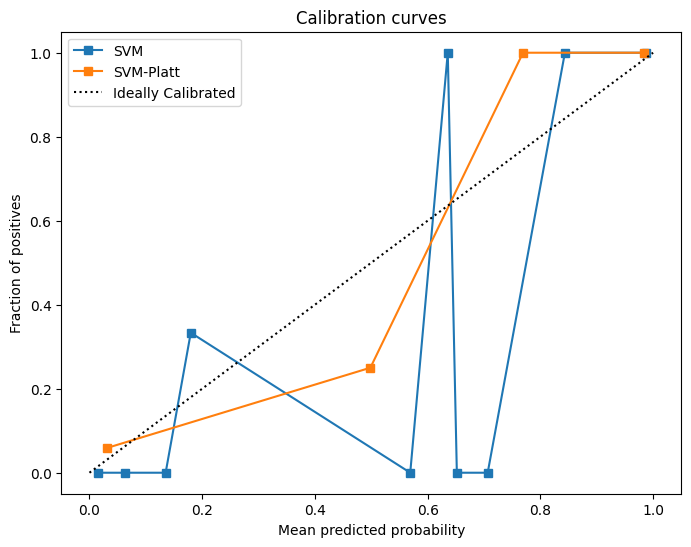

In [48]:
plt.figure(figsize=(8, 6))

prob_true_svm, prob_pred_svm = calibration_curve(y_test, y_prob, n_bins=5)
plt.plot(prob_pred, prob_true, "s-", label="SVM")

prob_true_platt, prob_pred_platt = calibration_curve(y_test, platt_probs, n_bins=5)

plt.plot(prob_pred_platt, prob_true_platt, "s-", label="SVM-Platt")
plt.plot([0, 1], [0, 1], "k:", label="Ideally Calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.show()

<div align="justify">

Now we calculate the [Brier scores](bs), [log loss](ll) as well as ECE and MCE before and after the logistic scaling. 
The results below indicate that Platt scaling has improved the calibration of the SVM probabilities, 
as reflected in the lower Brier score, ECE, and MCE for Platt scaling compared to the raw SVM probabilities. 

</div>

In [49]:
bs_svm = brier_score_loss(y_test, y_prob)
bs_platt = brier_score_loss(y_test, platt_probs)

ll_svm = log_loss(y_test, y_prob)
ll_platt = log_loss(y_test, platt_probs)

ece_svm = calculate_ece(prob_true_svm, prob_pred_svm, n_bins=5)
ece_platt = calculate_ece(prob_true_platt, prob_pred_platt, n_bins=5)

mce_svm = calculate_mce(prob_true_svm, prob_pred_svm, n_bins=5)
mce_platt = calculate_mce(prob_true_platt, prob_pred_platt, n_bins=5)

In [50]:
df_results = pd.DataFrame({
    'Method': ['SVM', 'SVM-Platt'],
    'Brier Score': [bs_svm, bs_platt],
    'Log Loss': [ll_svm, ll_platt],
    'ECE': [ece_svm, ece_platt],
    'MCE': [mce_svm, mce_platt]
})

# df_results["SVM"] = df_results["SVM"].round(4)
# df_results["SVM-Platt"] = df_results["SVM-Platt"].round(4)
df_results

,Method,Brier Score,Log Loss,ECE,MCE
0,SVM,0.054541,0.165716,0.231906,0.569125
1,SVM-Platt,0.048478,0.154304,0.130777,0.248421


<div align="justify">

```{note}
A lower Brier loss, for instance, does not necessarily mean a better calibrated model, 
it could also mean a worse calibrated model with much more discriminatory power, 
e.g., using many more features ({cite:t}`silva_classifier_2023`).
```

</div>

(ir)=
## Isotonic Regression

<div align="justify">

A difficulty of the binning method is that we have to choose the number of bins by cross-validation. 
If the dataset is small, or highly unbalanced, cross-validation is not likely to indicate the optimal number of bins. 
Also, the size of the bins is fixed and the position of the boundaries is chosen arbitrarily. 
If the boundaries are such that we average together the labels of examples that clearly should have different probability estimates, 
the binning method will fail to produce accurate probability estimates.

Isotonic regression, 
an intermediary approach between sigmoid fitting and binning, 
is also arguably the most common non-parametric form of regression ({cite:t}`guo_calibration_2017`), 
in which we assume that the function is chosen from the class of all isotonic (i.e., non-decreasing) functions.
If we assume that the classifier ranks examples correctly, 
the mapping from scores into probabilities is non-decreasing, 
and we can use isotonic regression to learn this mapping. 
A commonly used algorithm for computing the isotonic regression is pair-adjacent violators (PAV) ({cite:t}`ayer_empirical_1955`). 
This algorithm finds the stepwise-constant isotonic function that best fits the data according to a mean-squared error criterion ({cite:t}`zadr_tc02`).

Building upon the [Linear Regressor](linear) in the previous chapter, 
we utilize the Isotonic Regression for a comparison on the same dataset.

</div>

In [51]:
n = 200
X = np.arange(n)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(n,)) + 50.0 * np.log1p(np.arange(n))

lr = LinearRegression()
lr.fit(X[:, np.newaxis], y)
y_pred_lr = lr.predict(X[:, np.newaxis])

ir = IsotonicRegression(out_of_bounds="clip")
y_pred_ir = ir.fit_transform(X, y)

segments = [[[i, y[i]], [i, y_pred_ir[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(np.full(n, 0.5))

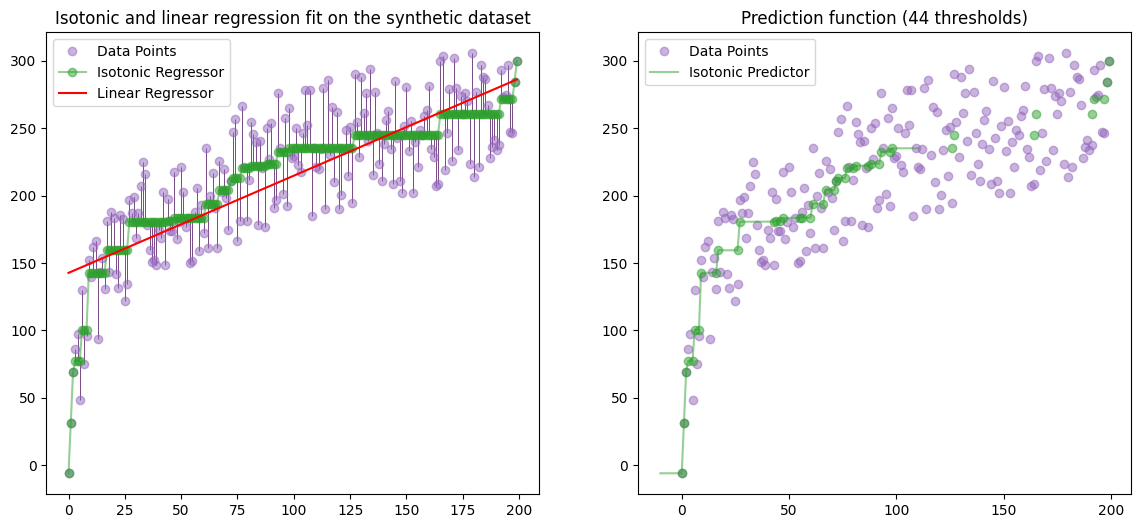

In [52]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.plot(X, y, "C4.", alpha=0.5, markersize=12)
ax0.plot(X, y_pred_ir, "C2.-", alpha=0.5, markersize=12)
ax0.plot(X, lr.predict(X[:, np.newaxis]), 'red') 
ax0.add_collection(lc)
ax0.legend(("Data Points", "Isotonic Regressor", "Linear Regressor")) # , loc="upper left" , 'lower right'
ax0.set_title("Isotonic and linear regression fit on the synthetic dataset")

x_test = np.linspace(-10, 110, 1000)
ax1.plot(X, y, "C4.", alpha=0.5, markersize=12)
ax1.plot(x_test, ir.predict(x_test), "C2-", alpha=0.5) 
ax1.plot(ir.X_thresholds_, ir.y_thresholds_, "C2.", alpha=0.5, markersize=12)
ax1.legend(("Data Points", "Isotonic Predictor"))
ax1.set_title("Prediction function (%d thresholds)" % len(ir.X_thresholds_))

plt.show()

<div align="justify">

Now we calculate the [mean squared error](mse) for both linear regression and isotonic regression. 
By plotting these calibration curves, 
we can visually assess the calibration of each regression model. 
Points closer to the black dashed line indicate the better calibration. 

</div>

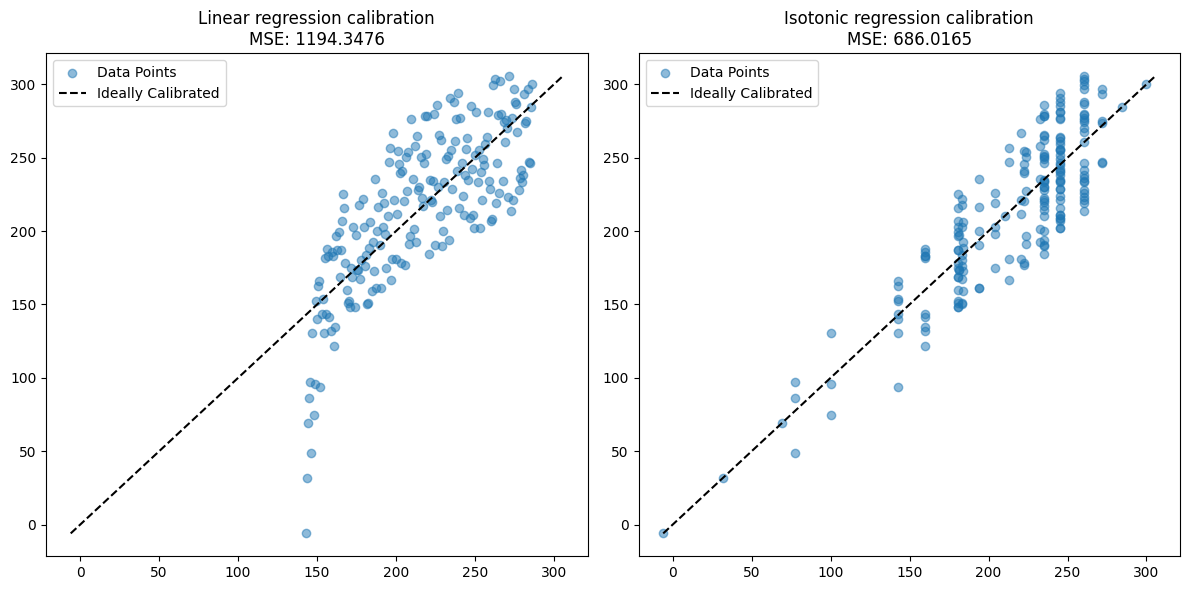

In [53]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_lr, y, alpha=0.5, label='Data Points')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black', label='Ideally Calibrated')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
plt.title(f'Linear regression calibration\nMSE: {mean_squared_error(y, y_pred_lr):.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_pred_ir, y, alpha=0.5, label='Data Points')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black', label='Ideally Calibrated')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
plt.title(f'Isotonic regression calibration\nMSE: {mean_squared_error(y, y_pred_ir):.4f}')
plt.legend()

plt.tight_layout()
plt.show()

## Gaussian Naive Bayes

<div align="justify">

Now let us take another example of gaussian naive bayes and compare previously introduced calibration methods in the following. 
We generate and split the synthetic dataset. 
To reduces the dimensionality of the data to 2D, 
we use principal component analysis (PCA) for visualization purposes.

</div>

In [54]:
X, y = make_classification(n_samples=1000, n_classes=2, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

nb_pca = GaussianNB()
nb_pca.fit(X_train_pca, y_train)

GaussianNB()

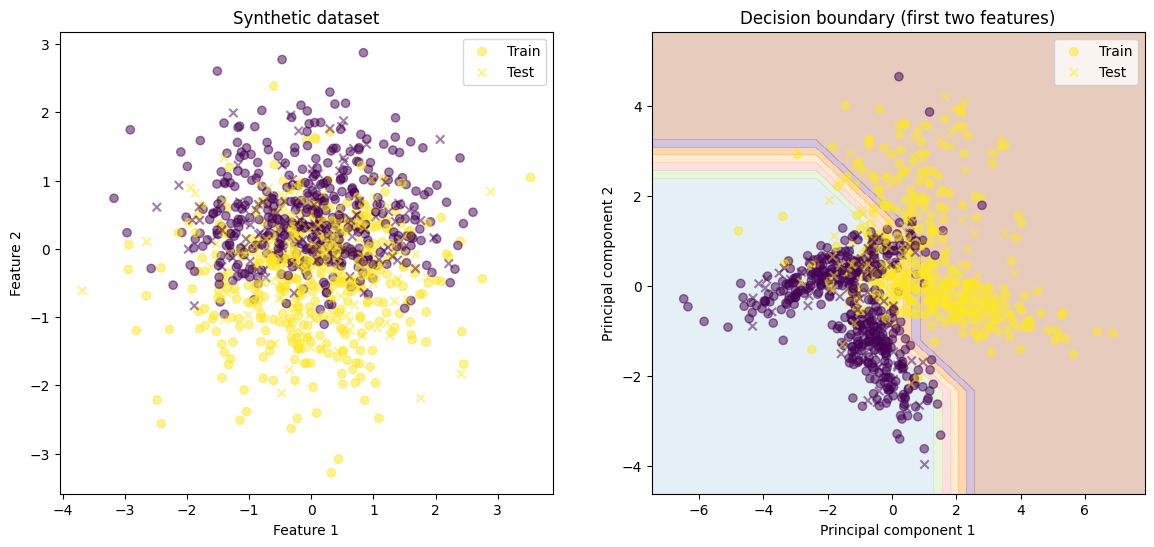

In [55]:
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
Z = nb_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', alpha=0.5, label='Train') 
ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', alpha=0.5, label='Test')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[0].set_title('Synthetic dataset')
ax[0].legend()

ax[1].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
ax[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, marker='o', alpha=0.5, label='Train')
ax[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, marker='x', alpha=0.5, label='Test')
ax[1].set_xlabel('Principal component 1')
ax[1].set_ylabel('Principal component 2')
ax[1].set_title('Decision boundary (first two features)')
ax[1].legend()

plt.show()

(vp)=
### Venn Predictors

<div align="justify">

Introduced by {cite:t}`vovk_self_2003`, 
Venn predictors are multi-probabilistic predictors with proven validity properties. 
The impossibility result described earlier for probabilistic prediction is circumvented in two ways: 
1. multiple probabilities for each label are outputted, with one of them being the valid one; 
1. the statistical tests for validity are restricted to calibration. 
More specifically, the probabilities must be matched by observed frequencies. 
As an example, if we make a number of probabilistic predictions with the probability estimate 0.9 these predictions should be correct in about 90% of the cases.

Now let us see the performance of the Venn predictors, as well parametric (e.g., Platt scaling) and non-parametric (isotonic calibration) methods with calibration curves. 

</div>

In [56]:
nb_isotonic = CalibratedClassifierCV(estimator=nb, cv=5, method='isotonic')
nb_isotonic.fit(X_train, y_train)
nb_sigmoid = CalibratedClassifierCV(estimator=nb, cv=5, method='sigmoid')
nb_sigmoid.fit(X_train, y_train)
nb_vennabers =  VennAbersCalibrator(estimator=nb, inductive=False, n_splits=5, precision=4)
nb_vennabers.fit(X_train, y_train)

prob_nb = nb.predict_proba(X_test)[:, 1]
prob_isotonic = nb_isotonic.predict_proba(X_test)[:, 1]
prob_sigmoid = nb_sigmoid.predict_proba(X_test)[:, 1]
prob_vennabers = nb_vennabers.predict_proba(X_test)[:, 1]

/Users/wery/Library/Python/3.9/lib/python/site-packages/venn_abers/venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


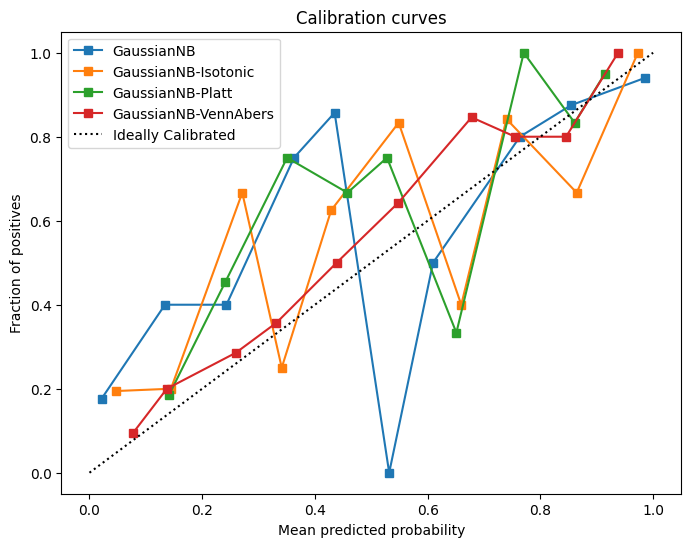

In [57]:
plt.figure(figsize=(8, 6))

prob_true, prob_pred = calibration_curve(y_test, prob_nb, n_bins=10)
plt.plot(prob_pred, prob_true, "s-", label='GaussianNB')
prob_true, prob_pred = calibration_curve(y_test, prob_isotonic, n_bins=10)
plt.plot(prob_pred, prob_true, "s-", label='GaussianNB-Isotonic')
prob_true, prob_pred = calibration_curve(y_test, prob_sigmoid, n_bins=10)
plt.plot(prob_pred, prob_true, "s-", label='GaussianNB-Platt')
prob_true, prob_pred = calibration_curve(y_test, prob_vennabers, n_bins=10)
plt.plot(prob_pred, prob_true, "s-", label='GaussianNB-VennAbers')
plt.plot([0, 1], [0, 1], linestyle='dotted', color='black', label='Ideally Calibrated')
plt.title('Calibration curves')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()

plt.show()

<div align="justify"> 

Let us again calculate some metrics such as Brier score, log loss, ECE, and MCE for each method. 
The result table is shown below for comparisons. 

</div>

In [58]:
bs_nb = brier_score_loss(y_test, prob_nb)
bs_isotonic = brier_score_loss(y_test, prob_isotonic)
bs_sigmoid = brier_score_loss(y_test, prob_sigmoid)
bs_vennabers = brier_score_loss(y_test, prob_vennabers)

ll_nb = log_loss(y_test, prob_nb)
ll_isotonic = log_loss(y_test, prob_isotonic)
ll_sigmoid = log_loss(y_test, prob_sigmoid)
ll_vennabers = log_loss(y_test, prob_vennabers)

nb_prob_true, nb_prob_pred = calibration_curve(y_test, prob_nb, n_bins=10, strategy='uniform')
nb_ece = calculate_ece(nb_prob_true, nb_prob_pred, bins)
nb_mce = calculate_mce(nb_prob_true, nb_prob_pred, bins)

isotonic_prob_true, isotonic_prob_pred = calibration_curve(y_test, prob_isotonic, n_bins=10, strategy='uniform')
isotonic_ece = calculate_ece(isotonic_prob_true, isotonic_prob_pred, bins)
isotonic_mce = calculate_mce(isotonic_prob_true, isotonic_prob_pred, bins)

sigmoid_prob_true, sigmoid_prob_pred = calibration_curve(y_test, prob_sigmoid, n_bins=10, strategy='uniform')
sigmoid_ece = calculate_ece(sigmoid_prob_true, sigmoid_prob_pred, bins)
sigmoid_mce = calculate_mce(sigmoid_prob_true, sigmoid_prob_pred, bins)

vennabers_prob_true, vennabers_prob_pred = calibration_curve(y_test, prob_vennabers, n_bins=10, strategy='uniform')
vennabers_ece = calculate_ece(vennabers_prob_true, vennabers_prob_pred, bins)
vennabers_mce = calculate_mce(vennabers_prob_true, vennabers_prob_pred, bins)

results = pd.DataFrame({
    'Method': ['GaussianNB', 'GaussianNB-Isotonic', 'GaussianNB-Platt', 'GaussianNB-VennAbers'],
    'Brier Score': [bs_nb, bs_isotonic, bs_sigmoid, bs_vennabers],
    'Log Loss': [ll_nb, ll_isotonic, ll_sigmoid, ll_vennabers],
    'ECE': [nb_ece, isotonic_ece, sigmoid_ece, vennabers_ece],
    'MCE': [nb_mce, isotonic_mce, sigmoid_mce, vennabers_mce]
})

results

,Method,Brier Score,Log Loss,ECE,MCE
0,GaussianNB,0.151764,0.603156,0.213120,0.531759
1,GaussianNB-Isotonic,0.139083,0.437506,0.175728,0.395541
2,GaussianNB-Platt,0.138047,0.436202,0.188642,0.399361
3,GaussianNB-VennAbers,0.134650,0.423458,0.060841,0.168206


<div align="justify"> 

As shown in the table, Venn predictors exhibit superior performance among all other methods measured by proposed metrics. 
We propose the following hypothesis: 
1. Unlike Platt scaling, 
which assumes a parametric form (sigmoid function) to map predicted probabilities, 
Venn predictors do not make any parametric assumptions. 
This non-parametric method can be more flexible and adapt better to the true underlying distribution of the data.
1. Venn predictors generate multiple calibrated scores (one for each possible label) and use these to produce interval predictions. 
This approach inherently incorporates the measure of epistemic uncertainty, 
which can lead to more reliable probability estimates. 

We also provide histogram counts for predicted probabilities in terms of different methods to have a better understanding of distribution and calibration of prediction.

</div>

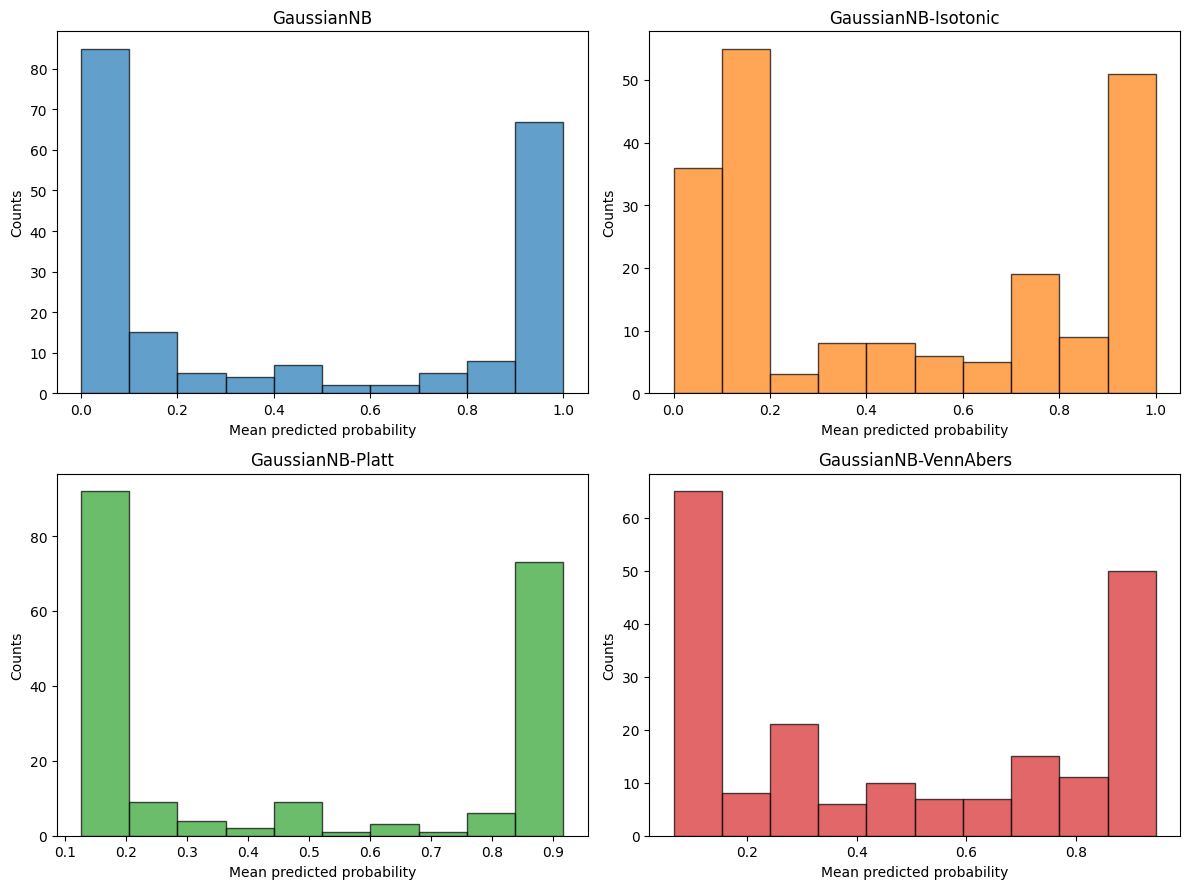

In [59]:
plt.figure(figsize=(12, 9)) 

plt.subplot(2, 2, 1)
plt.hist(prob_nb, bins=10, edgecolor='k', alpha=0.7)
plt.title('GaussianNB')
plt.xlabel('Mean predicted probability')
plt.ylabel('Counts')

plt.subplot(2, 2, 2)
plt.hist(prob_isotonic, bins=10, edgecolor='k', color='tab:orange', alpha=0.7)
plt.title('GaussianNB-Isotonic')
plt.xlabel('Mean predicted probability')
plt.ylabel('Counts')

plt.subplot(2, 2, 3)
plt.hist(prob_sigmoid, bins=10, edgecolor='k', color='tab:green', alpha=0.7)
plt.title('GaussianNB-Platt')
plt.xlabel('Mean predicted probability')
plt.ylabel('Counts')

plt.subplot(2, 2, 4)
plt.hist(prob_vennabers, bins=10, edgecolor='k', color='tab:red', alpha=0.7)
plt.title('GaussianNB-VennAbers')
plt.xlabel('Mean predicted probability')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

<div align="justify">

```{note}
Venn predictors are related to the more well-known Conformal Prediction (CP) framework, 
which was introduced as an approach for associating predictions with confidence measures ({cite:t}`saunders_transduction_1999`). 
```

</div>